In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
import seaborn as sns

Using TensorFlow backend.


In [2]:
def load_data(): 
    train = pd.read_json('data/train.json')
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.fillna(0)
    
    test = pd.read_json('data/test.json')
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.fillna(0)
    
    return(train, test)

In [3]:
(train, test) = load_data()
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


In [4]:
x_train_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_train_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x_test_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_test_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])

X_train = np.concatenate([ x_train_band1[:, :, :, np.newaxis],  
                           x_train_band2[:, :, :, np.newaxis] ],
                         axis=-1)

X_angle_train = np.array(train.inc_angle)


Y_train = np.array(train["is_iceberg"])


X_test = np.concatenate([ x_test_band1[:, :, :, np.newaxis],  
                          x_test_band2[:, :, :, np.newaxis] ],
                        axis=-1)

X_angle_test = np.array(test.inc_angle)

id_test = test.id

print('Freeing some memory')
train = []
test = []

Freeing some memory


In [5]:
def normalize(dataset):
    shape = dataset.shape
    flattened  = dataset.flatten()
    normalized = (flattened - flattened.mean()) / (flattened.max() - flattened.min())
    print(normalized.shape)
    
    return normalized.reshape(shape)

# X_train = normalize(X_train)
# X_test = normalize(X_test)
# X_angle_train = normalize(X_angle_train)
# X_angle_test = normalize(X_angle_test)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[1:])
X_train.max()

(1604, 75, 75, 2)
(8424, 75, 75, 2)
(75, 75, 2)


34.574917

In [7]:
image_input = Input(shape=X_train.shape[1:])
angle_input = Input(shape=(1,))

In [8]:
conv_dropout = 0.25
dense_dropout = 0.5

img_layers = Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same')(image_input)
img_layers = Activation('relu')(img_layers)
img_layers = Conv2D(32, (3, 3), padding='same')(img_layers)
img_layers = Activation('relu')(img_layers)

img_layers = MaxPooling2D(pool_size=(2, 2))(img_layers)
img_layers = Dropout(conv_dropout)(img_layers)

img_layers = Conv2D(64, (3, 3))(img_layers)
img_layers = Activation('relu')(img_layers)
img_layers = Conv2D(64, (3, 3))(img_layers)
img_layers = Activation('relu')(img_layers)

img_layers = MaxPooling2D(pool_size=(2, 2))(img_layers)
img_layers = Dropout(conv_dropout)(img_layers)

img_layers = Conv2D(128, (3, 3))(img_layers)
img_layers = Activation('relu')(img_layers)
img_layers = Conv2D(128, (3, 3))(img_layers)
img_layers = BatchNormalization()(img_layers)
img_layers = Activation('relu')(img_layers)

img_layers = MaxPooling2D(pool_size=(2, 2))(img_layers)
img_layers = Dropout(conv_dropout)(img_layers)

img_layers = Flatten()(img_layers)

img_layers = Dense(128)(img_layers)
img_layers = BatchNormalization()(img_layers)
img_layers = Activation('relu')(img_layers)

img_layers = Dense(1)(img_layers)
img_layers = Activation('sigmoid')(img_layers)

model = Model(inputs=[image_input, angle_input], outputs=img_layers)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [10]:
batch_size = 100
epochs = 50
patience = 2
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=patience)

# cw = {0 : 1., 1: 2.9} # 1:2.9 is best so far! 
# print(cw)

history = model.fit([X_train, X_angle_train], Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True, 
                    callbacks=[early_stopping], 
                    validation_split=0.1)

Train on 1443 samples, validate on 161 samples
Epoch 1/50
1443/1443 [==============================] - 38s - loss: 0.8071 - acc: 0.5260 - val_loss: 0.5376 - val_acc: 0.7826

In [11]:
predictions = model.predict([X_test, X_angle_test])

In [12]:
pred = pd.DataFrame(predictions, columns=['is_iceberg'])
id_test = pd.DataFrame(id_test)
out_pred = pd.concat([id_test, pred], axis=1)

# out_pred = out_pred.fillna(0) # hack
out_pred.head(10)

,id,is_iceberg
0,5941774d,0.133065
1,4023181e,0.661054
2,b20200e4,0.002175
3,e7f018bb,0.999886
4,4371c8c3,0.471778
5,a8d9b1fd,0.027003
6,29e7727e,0.199371
7,92a51ffb,0.999923
8,c769ac97,0.004651
9,aee0547d,0.000632


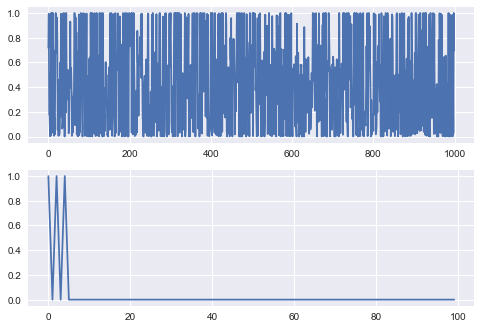

In [13]:
plt.subplot(2,1,1)
plt.plot(predictions[-1000:])

plt.subplot(2,1,2)
plt.plot(Y_train[-100:])

# pd.DataFrame(Y_train).hist()
plt.show()

In [14]:
out_pred.to_csv('./output/predictions.csv', index=False)